### Executive Summary (CPS Comebackers)

- **Problem**: Identify adults (25–59) with some college but no BA, not enrolled at baseline, who re-enroll during the CPS panel.
- **Approach**: Compare tuned XGBoost vs logistic regression on CPS-only features. Select thresholds on validation by F1. Evaluate on a held-out test set. Assess calibration.

- **Key results (Test set)**:
  - **PR-AUC**: XGBoost 0.1233 vs Logistic 0.1120 (XGB +10% relative)
  - **AUC**: XGBoost 0.7119 vs Logistic 0.7058 (small gain)
  - **F1 at validation F1-opt thresholds**: XGB 0.1893 (t=0.662) vs LR 0.1866 (t=0.687)
  - **Confusion matrices**:
    - XGB (t=0.662): [[16184, 1562], [656, 259]] → P≈0.142, R≈0.283
    - LR  (t=0.687): [[15920, 1826], [633, 282]] → P≈0.134, R≈0.308

- **Calibration**: Isotonic calibration substantially improves probability quality (Test Brier ↓ 75.1%, ECE ↓ 99.7%). Use `calibrated_clf` for probability outputs; apply your chosen threshold to calibrated probabilities.

- **Model capacity & data limits**: Learning curves indicate **High Variance (Overfitting)** with modest absolute PR-AUC, consistent with limited predictive signal in CPS-only features. Expect low precision on positives at useful recall.

- **Recommendations**:
  - Use XGBoost with calibrated probabilities; choose threshold to meet operational precision/recall targets. Report PR-AUC + thresholded metrics.
  - For real lift, add richer features beyond CPS (education history granularity, longitudinal earnings/benefits, local education supply). If staying CPS-only, consider the ranking (top-N outreach) rather than strict classification.



# CPS Comebacker Prediction Model

## Project Overview
**Goal:** Predict "comebackers" - individuals aged 25-59 with some college but no BA who re-enroll in school during their ~16 month CPS panel period.

**Target Variable:** `comebacker` (binary: 1 if person re-enrolls, 0 otherwise)

**Population:** 
- Age 25-59
- Some college but no BA (between 1 semester and 3 years, including associates degree holders)
- NOT enrolled in school during first month of CPS interview

**Preprocessing:**
- Use CPS monthly data 2010 - Today
- Make use of longitudinal component. Filter down to some college no BA population 
- Limit again to those unenrolled during their first interview
- Identify those who do and do not re-enroll at some point in their next 7 interviews.
- Collapse to individual level, preserving initial characteristics from first interview. 

## Analysis Plan

### 1. Initial Sanity Checks
- Confirm sample size and memory usage (< 3GB)
- Check class balance of `comebacker` 
- Missing value audit
- Screen for data leakage (drop post-month-1 variables)

### 2. Train/Validation/Test Split
- 60% training, 20% validation, 20% test
- Stratified by `comebacker` to maintain class balance

### 3. Feature Engineering
- Select features from demographics, geography, labor status, education, etc.
- Collapse rare categories (< 200 observations) to 'Other'
- Median imputation for numeric, 'missing' category for categorical
- One-hot encoding with handle_unknown='ignore'

### 4. Model Training
- XGBoost with `scale_pos_weight` for class imbalance
- Hyperparameter tuning via randomized search
- 5-fold stratified CV with PR-AUC metric
- Early stopping on validation set

### 5. Evaluation
- Learning curves for bias-variance assessment
- Comparison with logistic regression baseline
- SHAP values for interpretability
- Threshold analysis and calibration curves

In [26]:
# Core
import os
import warnings
import pandas as pd
import numpy as np
import json

# ML
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve, auc)

# Explainability
import shap
import re

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Add these imports to your first cell alongside the existing ones

# Additional ML imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import (average_precision_score, roc_curve, 
                             brier_score_loss, confusion_matrix, f1_score)

print("✓ Additional ML libraries imported successfully!")


# Housekeeping
warnings.filterwarnings('ignore')
project_dir = '/Users/tomerstern/Documents/GitHub/acs_projects_personal/predicting college comebackers'
if os.path.isdir(project_dir):
    os.chdir(project_dir)
else:
    raise FileNotFoundError(f"Project directory not found: {project_dir}")
print(f"Working directory set to: {os.getcwd()}")

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

print("✓ Libraries imported successfully!")


✓ Additional ML libraries imported successfully!
Working directory set to: /Users/tomerstern/Documents/GitHub/acs_projects_personal/predicting college comebackers
✓ Libraries imported successfully!


In [27]:
# Load the data
df = pd.read_csv('data/cps_collapsed.csv')

print("="*60)
print("DATA LOADED SUCCESSFULLY")
print("="*60)
print(f"\nDataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"✓ Well under 3 GB threshold")

# Quick preview
print(f"\nColumn types:")
print(df.dtypes.value_counts())
print(f"\nFirst 3 rows preview:")
df.head(3)

DATA LOADED SUCCESSFULLY

Dataset shape: 93,305 rows × 85 columns
Memory usage: 154.82 MB
✓ Well under 3 GB threshold

Column types:
int64      65
object     15
float64     4
bool        1
Name: count, dtype: int64

First 3 rows preview:


,cpsidp,some_college_start,some_college_noBA_start,disabled,born_abroad_american_parents,naturalized_citizen,not_a_citizen,hs_or_ged,associates,metro,wage,some_college_noBA_end,BA_plus_end,enrolled_start,initial_educd,ending_educd,cohort,age,year,state,race_ethnicity,sex,soc,kids,kids_under5,veteran,race_sex,classwkr,initial_edcyc,enrolled_during_panel,faminc_under_5000,faminc_5000_7499,faminc_7500_9999,faminc_10000_12499,faminc_12500_14999,faminc_15000_19999,faminc_20000_24999,faminc_25000_29999,faminc_30000_34999,faminc_35000_39999,faminc_40000_49999,faminc_50000_59999,faminc_60000_74999,faminc_75000_99999,faminc_100000_149999,faminc_150000_and_over,nativity_unknown,nativity_both_parents_native,nativity_father_foreign_mother_native,nativity_mother_foreign_father_native,nativity_both_parents_foreign,nativity_foreign_born,employed,unemployed,armed_forces,not_in_labor_force,in_labor_force,married_spouse_present,married_spouse_absent,separated,divorced,widowed,never_married_single,region,wage_bucket,wage_bucket_0,wage_bucket_1_20000,wage_bucket_20001_30000,wage_bucket_30001_40000,wage_bucket_40001_50000,wage_bucket_50001_60000,wage_bucket_60001_70000,wage_bucket_70001_80000,wage_bucket_80001_90000,wage_bucket_90001_100000,wage_bucket_100001_plus,soc2_name,soc2,l_weight,public_sector,rural,urban,comebacker,industry_2_digits,industry_group
0,20130100024404,1,1,0,0,0,0,0,0,not in central/principal city,NaN,1,0,0,"some college but no degree,the first or freshm...","some college but no degree,the second or sophm...",2013-1,39,2013,alabama,Black Non-Hispanic,male,NaN,1,0,0,"Black Non-Hispanic,male","private, for profit",the first or freshman year,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,east south central division,0,1,0,0,0,0,0,0,0,0,0,0,Other / Unknown,NaN,52356.661,0,0,1,0,33.000,Manufacturing
1,20130100036103,1,1,0,0,0,0,0,0,not in central/principal city,NaN,1,0,0,"some college but no degree,the first or freshm...","some college but no degree,the first or freshm...",2013-1,26,2013,alabama,White Non-Hispanic,female,39-5012,0,0,0,"White Non-Hispanic,female","private, for profit",the first or freshman year,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,east south central division,"20,001-30,000",0,0,1,0,0,0,0,0,0,0,0,Personal Care and Service Occupations,39.000,8096.164,0,0,1,0,81.000,Other Services (Except Public Administration)
2,20130100037401,1,1,0,0,0,0,0,0,not in central/principal city,NaN,1,0,0,"some college but no degree,the third or junior...","some college but no degree,the first or freshm...",2013-1,49,2013,alabama,White Non-Hispanic,male,49-9043,0,0,0,"White Non-Hispanic,male","private, for profit",the third or junior year,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,east south central division,"40,001-50,000",0,0,0,0,1,0,0,0,0,0,0,"Installation, Maintenance, and Repair Occupations",49.000,37707.460,0,0,1,0,32.000,Manufacturing


In [28]:
# Check class balance for our target variable
print("="*60)
print("CLASS BALANCE CHECK: COMEBACKER VARIABLE")
print("="*60)

# Get counts and percentages
comebacker_counts = df['comebacker'].value_counts()
comebacker_pct = df['comebacker'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
print(f"  Non-comebackers (0): {comebacker_counts[0]:,} ({comebacker_pct[0]:.2f}%)")
print(f"  Comebackers (1):     {comebacker_counts[1]:,} ({comebacker_pct[1]:.2f}%)")
print(f"\nComebacker rate: {df['comebacker'].mean():.4f} ({df['comebacker'].mean()*100:.2f}%)")

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = comebacker_counts[0] / comebacker_counts[1]
print(f"\nImbalance ratio: {scale_pos_weight:.2f}:1")
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")

# Decision on handling imbalance
if comebacker_pct[1] < 0.5:
    print("\n⚠️ SEVERE IMBALANCE: Less than 0.5% positive class")
    print("   Consider: SMOTE or synthetic oversampling")
elif comebacker_pct[1] < 5:
    print("\n⚠️ SIGNIFICANT IMBALANCE: Less than 5% positive class")
    print("   Strategy: Use scale_pos_weight and PR-AUC metric")
else:
    print("\n✓ Class imbalance is manageable with scale_pos_weight")

CLASS BALANCE CHECK: COMEBACKER VARIABLE

Class Distribution:
  Non-comebackers (0): 88,728 (95.09%)
  Comebackers (1):     4,577 (4.91%)

Comebacker rate: 0.0491 (4.91%)

Imbalance ratio: 19.39:1
Calculated scale_pos_weight for XGBoost: 19.39

⚠️ SIGNIFICANT IMBALANCE: Less than 5% positive class
   Strategy: Use scale_pos_weight and PR-AUC metric


In [29]:
# Check for missing values
print("="*60)
print("MISSING VALUES AUDIT")
print("="*60)

missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df) * 100).round(2)

# Create summary dataframe
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Pct': missing_pct.values
}).sort_values('Missing_Pct', ascending=False)

# Show only columns with missing values
missing_with_values = missing_df[missing_df['Missing_Count'] > 0]

if len(missing_with_values) > 0:
    print(f"\nColumns with missing values: {len(missing_with_values)}/{len(df.columns)}")
    print("\nTop 10 columns by missingness:")
    print(missing_with_values.head(10).to_string(index=False))
else:
    print("\n✓ No missing values detected in the dataset!")

# Identify data types for imputation strategy
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

print(f"\nColumn Type Summary:")
print(f"  Numeric columns: {len(numeric_cols)}")
print(f"  Categorical columns: {len(categorical_cols)}")
print(f"  Boolean columns: {len(bool_cols)}")
print(f"\nImputation Strategy:")
print(f"  • Numeric: Median imputation")
print(f"  • Categorical: Add 'missing' category")

MISSING VALUES AUDIT

Columns with missing values: 5/85

Top 10 columns by missingness:
           Column  Missing_Count  Missing_Pct
             wage          93305      100.000
              soc          31252       33.490
             soc2          31252       33.490
   industry_group          22486       24.100
industry_2_digits          22032       23.610

Column Type Summary:
  Numeric columns: 69
  Categorical columns: 15
  Boolean columns: 1

Imputation Strategy:
  • Numeric: Median imputation
  • Categorical: Add 'missing' category


In [30]:
# Identify potential leakage variables and features to use
print("="*60)
print("FEATURE IDENTIFICATION & LEAKAGE CHECK")
print("="*60)

# Check for potential leakage columns (post-baseline information)
leakage_candidates = ['ending_educd', 'some_college_noBA_end', 'enrolled_during_panel', 'enrolled_start']
found_leakage = [col for col in leakage_candidates if col in df.columns]

if found_leakage:
    print(f"⚠️ Found potential leakage columns: {found_leakage}")
    print("   These contain post-baseline information and will be dropped\n")
    
    # Special check for enrolled_start to verify it's all zeros
    if 'enrolled_start' in found_leakage:
        enrolled_start_values = df['enrolled_start'].value_counts()
        print(f"   'enrolled_start' values: {enrolled_start_values.to_dict()}")
        if len(enrolled_start_values) == 1 and enrolled_start_values.index[0] == 0:
            print(f"   ✓ Confirmed: All 'enrolled_start' values are 0 (nobody enrolled at start)\n")
else:
    print("✓ No obvious leakage columns detected\n")

# List all available columns grouped by category
print("Available Features by Category:")
print("-" * 40)

# Demographics
demo_features = ['age', 'sex', 'race_ethnicity']
demo_available = [f for f in demo_features if f in df.columns]
print(f"Demographics: {demo_available}")

# Geography  
geo_features = ['region', 'metro', 'urban', 'rural', 'state']
geo_available = [f for f in geo_features if f in df.columns]
print(f"Geography: {geo_available} (will drop 'state')")

# Labor status
labor_features = ['employed', 'unemployed', 'not_in_labor_force', 'in_labor_force', 'public_sector', 'armed_forces']
labor_available = [f for f in labor_features if f in df.columns]
print(f"Labor Status: {labor_available}")

# Education
edu_features = ['initial_educd', 'initial_edcyc', 'some_college_start', 'some_college_noBA_start', 'associates', 'hs_or_ged']
edu_available = [f for f in edu_features if f in df.columns]
print(f"Education: {edu_available}")

# Household
household_features = ['married_spouse_present', 'married_spouse_absent', 'separated', 'divorced', 'widowed', 'never_married_single', 'kids', 'kids_under5']
household_available = [f for f in household_features if f in df.columns]
print(f"Household: {household_available}")

# Economic
econ_features = [col for col in df.columns if 'faminc_' in col or col == 'wage_bucket']
print(f"Economic: {len(econ_features)} features (family income dummies + wage bucket)")

# Count total available features (excluding target and leakage)
exclude_cols = ['comebacker'] + found_leakage + ['state', 'race_sex', 'soc2', 'industry_2_digits']  # Exclude codes; allow classwkr
potential_features = [col for col in df.columns if col not in exclude_cols]
print(f"\n✓ Total potential features: {len(potential_features)}")
print(f"   (Excluding: target variable, leakage columns, state, codes, and redundant columns)")

FEATURE IDENTIFICATION & LEAKAGE CHECK
⚠️ Found potential leakage columns: ['ending_educd', 'some_college_noBA_end', 'enrolled_during_panel', 'enrolled_start']
   These contain post-baseline information and will be dropped

   'enrolled_start' values: {0: 93305}
   ✓ Confirmed: All 'enrolled_start' values are 0 (nobody enrolled at start)

Available Features by Category:
----------------------------------------
Demographics: ['age', 'sex', 'race_ethnicity']
Geography: ['region', 'metro', 'urban', 'rural', 'state'] (will drop 'state')
Labor Status: ['employed', 'unemployed', 'not_in_labor_force', 'in_labor_force', 'public_sector', 'armed_forces']
Education: ['initial_educd', 'initial_edcyc', 'some_college_start', 'some_college_noBA_start', 'associates', 'hs_or_ged']
Household: ['married_spouse_present', 'married_spouse_absent', 'separated', 'divorced', 'widowed', 'never_married_single', 'kids', 'kids_under5']
Economic: 17 features (family income dummies + wage bucket)

✓ Total potential 

In [31]:
# Check the missingness pattern for occupation and industry
print("=" * 60)
print("OCCUPATION & INDUSTRY MISSINGNESS ANALYSIS")
print("=" * 60)

# Check if missing occupation/industry correlates with employment status
print("Checking if missing values correspond to unemployment/not in labor force:\n")

# Create a temporary dataframe to analyze
miss_analysis = pd.DataFrame({
    "has_occupation": ~df["soc2"].isna(),
    "has_industry":   ~df["industry_2_digits"].isna(),
    "employed":        df["employed"],
    "unemployed":      df["unemployed"],
    "not_in_labor_force": df["not_in_labor_force"],
})

# Cross-tabulation
print("Employment status vs. Having occupation data:")
print(pd.crosstab(miss_analysis["has_occupation"], miss_analysis["employed"], margins=True))

print("\nEmployment status for those WITHOUT occupation data:")
no_occ = df[df["soc2"].isna()]
print(f"  Employed: {no_occ['employed'].sum()} ({no_occ['employed'].mean():.1%})")
print(f"  Unemployed: {no_occ['unemployed'].sum()} ({no_occ['unemployed'].mean():.1%})")
print(f"  Not in labor force: {no_occ['not_in_labor_force'].sum()} ({no_occ['not_in_labor_force'].mean():.1%})")

print("\nEmployment status for those WITH occupation data:")
has_occ = df[~df["soc2"].isna()]
print(f"  Employed: {has_occ['employed'].sum()} ({has_occ['employed'].mean():.1%})")
print(f"  Unemployed: {has_occ['unemployed'].sum()} ({has_occ['unemployed'].mean():.1%})")
print(f"  Not in labor force: {has_occ['not_in_labor_force'].sum()} ({has_occ['not_in_labor_force'].mean():.1%})")

print("\n✓ Recommendation: Keep these features and treat missing as 'Not Employed' or 'No Occupation'")


OCCUPATION & INDUSTRY MISSINGNESS ANALYSIS
Checking if missing values correspond to unemployment/not in labor force:

Employment status vs. Having occupation data:
employed            0      1    All
has_occupation                     
False           15506  15746  31252
True             2452  59601  62053
All             17958  75347  93305

Employment status for those WITHOUT occupation data:
  Employed: 15746 (50.4%)
  Unemployed: 688 (2.2%)
  Not in labor force: 14818 (47.4%)

Employment status for those WITH occupation data:
  Employed: 59601 (96.0%)
  Unemployed: 2452 (4.0%)
  Not in labor force: 0 (0.0%)

✓ Recommendation: Keep these features and treat missing as 'Not Employed' or 'No Occupation'


In [32]:
# Define comprehensive feature list based on categories
print("="*60)
print("COMPREHENSIVE FEATURE SELECTION")
print("="*60)

# Define all feature categories based on the guidance document
feature_groups = {
    'Demographics': ['age', 'sex', 'race_ethnicity'],
    
    'Nativity_Citizenship': [
        'nativity_unknown', 'nativity_both_parents_native',
        'nativity_father_foreign_mother_native', 'nativity_mother_foreign_father_native',
        'nativity_both_parents_foreign', 'nativity_foreign_born',
        'born_abroad_american_parents', 'naturalized_citizen', 'not_a_citizen'
    ],
    
    'Disability_Veteran': ['disabled', 'veteran'],
    
    'Household': [
        'married_spouse_present', 'married_spouse_absent', 'separated',
        'divorced', 'widowed', 'never_married_single',
        'kids', 'kids_under5'
    ],
    
    'Geography': ['region', 'metro', 'urban', 'rural'],  # Excluding 'state'
    
    'Labor_Status': [
        'employed', 'unemployed', 'not_in_labor_force',
        'in_labor_force', 'public_sector', 'armed_forces'
    ],
    
    'Occupation_Industry': [
        'soc2_name', 'soc2', 'industry_2_digits', 'industry_group'
    ],
    
    'Economic': [
        'wage_bucket',
        'faminc_under_5000', 'faminc_5000_7499', 'faminc_7500_9999',
        'faminc_10000_12499', 'faminc_12500_14999', 'faminc_15000_19999',
        'faminc_20000_24999', 'faminc_25000_29999', 'faminc_30000_34999',
        'faminc_35000_39999', 'faminc_40000_49999', 'faminc_50000_59999',
        'faminc_60000_74999', 'faminc_75000_99999', 'faminc_100000_149999',
        'faminc_150000_and_over'
    ],
    
    'Education_Entry': [
        'initial_educd', 'some_college_start', 'some_college_noBA_start',
        'associates', 'hs_or_ged', 'initial_edcyc'
    ]
}

# Collect all features and check availability
all_features = []
feature_summary = []

for category, features in feature_groups.items():
    available = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    all_features.extend(available)
    
    feature_summary.append({
        'Category': category,
        'Total': len(features),
        'Available': len(available),
        'Missing': len(missing)
    })
    
    if missing:
        print(f"{category}: {len(available)}/{len(features)} available")
        print(f"  Missing: {missing[:5]}..." if len(missing) > 5 else f"  Missing: {missing}")

# Remove duplicates
all_features = list(set(all_features))

# Summary table
summary_df = pd.DataFrame(feature_summary)
print("\nFeature Availability Summary:")
print(summary_df.to_string(index=False))
print(f"\n✓ Total unique features selected: {len(all_features)}")

# Store feature lists by type for later preprocessing
numeric_features = [f for f in all_features if f in numeric_cols]
categorical_features = [f for f in all_features if f in categorical_cols]
print(f"\nBreakdown by type:")
print(f"  Numeric: {len(numeric_features)}")
print(f"  Categorical: {len(categorical_features)}")

COMPREHENSIVE FEATURE SELECTION

Feature Availability Summary:
            Category  Total  Available  Missing
        Demographics      3          3        0
Nativity_Citizenship      9          9        0
  Disability_Veteran      2          2        0
           Household      8          8        0
           Geography      4          4        0
        Labor_Status      6          6        0
 Occupation_Industry      4          4        0
            Economic     17         17        0
     Education_Entry      6          6        0

✓ Total unique features selected: 59

Breakdown by type:
  Numeric: 50
  Categorical: 9


In [33]:
# Handle missing values in occupation and industry features
print("=" * 60)
print("HANDLING OCCUPATION & INDUSTRY MISSING VALUES")
print("=" * 60)

# Make a copy to preserve original
df_processed = df.copy()

# ── Numeric codes ────────────────────────────────────────────────────────
if "soc2" in df_processed.columns:
    df_processed["soc2"].fillna(0, inplace=True)
    print("✓ Filled missing soc2 with 0 (indicating no occupation)")

if "industry_2_digits" in df_processed.columns:
    df_processed["industry_2_digits"].fillna(0, inplace=True)
    print("✓ Filled missing industry_2_digits with 0 (indicating no industry)")

# After imputation, treat code columns as categorical (cast to string)
converted_cols = []
if "soc2" in df_processed.columns:
    df_processed["soc2"] = df_processed["soc2"].astype(int).astype(str)
    converted_cols.append("soc2")
if "industry_2_digits" in df_processed.columns:
    df_processed["industry_2_digits"] = df_processed["industry_2_digits"].astype(int).astype(str)
    converted_cols.append("industry_2_digits")
if converted_cols:
    print(f"✓ Cast to categorical (string): {', '.join(converted_cols)}")

# ── Categorical names ────────────────────────────────────────────────────
if "soc2_name" in df_processed.columns:
    df_processed["soc2_name"].fillna("Not Employed/No Occupation", inplace=True)
    print("✓ Filled missing soc2_name with 'Not Employed/No Occupation'")

if "industry_group" in df_processed.columns:
    df_processed["industry_group"].fillna("Not Employed/No Industry", inplace=True)
    print("✓ Filled missing industry_group with 'Not Employed/No Industry'")

# ── Wage bucket cleanup ──────────────────────────────────────────────────
if "wage_bucket" in df_processed.columns:
    wage_zero_count = (df_processed["wage_bucket"] == "0").sum()
    print(f"\nWage bucket = '0': {wage_zero_count} cases")
    if wage_zero_count > 0:
        print("  This likely indicates no wages/not employed")
        df_processed["wage_bucket"].replace("0", "No wages", inplace=True)

# ── Quick check ──────────────────────────────────────────────────────────
print("\nUpdated missing values:")
for col in ["soc2", "industry_2_digits", "soc2_name", "industry_group"]:
    if col in df_processed.columns:
        missing = df_processed[col].isna().sum()
        print(f"  {col}: {missing} missing")


HANDLING OCCUPATION & INDUSTRY MISSING VALUES
✓ Filled missing soc2 with 0 (indicating no occupation)
✓ Filled missing industry_2_digits with 0 (indicating no industry)
✓ Cast to categorical (string): soc2, industry_2_digits
✓ Filled missing soc2_name with 'Not Employed/No Occupation'
✓ Filled missing industry_group with 'Not Employed/No Industry'

Wage bucket = '0': 33716 cases
  This likely indicates no wages/not employed

Updated missing values:
  soc2: 0 missing
  industry_2_digits: 0 missing
  soc2_name: 0 missing
  industry_group: 0 missing


In [34]:
# ──────────────────────────────────────────────────────────────
# COMPREHENSIVE FEATURE SELECTION
# ──────────────────────────────────────────────────────────────
print("=" * 60)
print("COMPREHENSIVE FEATURE SELECTION")
print("=" * 60)

feature_groups = {
    # ---- Core categories -------------------------------------
    "Demographics": ["age", "sex", "race_ethnicity"],

    "Nativity_Citizenship": [
        "nativity_unknown", "nativity_both_parents_native",
        "nativity_father_foreign_mother_native", "nativity_mother_foreign_father_native",
        "nativity_both_parents_foreign", "nativity_foreign_born",
        "born_abroad_american_parents", "naturalized_citizen", "not_a_citizen",
    ],

    "Disability_Veteran": ["disabled", "veteran"],

    "Household": [
        "married_spouse_present", "married_spouse_absent", "separated",
        "divorced", "widowed", "never_married_single",
        "kids", "kids_under5",
    ],

    "Geography": ["region", "metro", "urban", "rural"],  # Excluding “state”

    "Labor_Status": [
        "employed", "unemployed", "not_in_labor_force",
        "in_labor_force", "armed_forces", "classwkr",
    ],

    "Occupation_Industry": [
        "soc2_name", "industry_group",
    ],

    "Economic": [
        "wage_bucket",
        "faminc_under_5000", "faminc_5000_7499", "faminc_7500_9999",
        "faminc_10000_12499", "faminc_12500_14999", "faminc_15000_19999",
        "faminc_20000_24999", "faminc_25000_29999", "faminc_30000_34999",
        "faminc_35000_39999", "faminc_40000_49999", "faminc_50000_59999",
        "faminc_60000_74999", "faminc_75000_99999", "faminc_100000_149999",
        "faminc_150000_and_over",
    ],

    "Education_Entry": [
        "initial_educd", "some_college_start", "some_college_noBA_start",
        "associates", "hs_or_ged",'initial_edcyc',
    ],
}

all_features, feature_summary = [], []

for category, feats in feature_groups.items():
    available = [f for f in feats if f in df_processed.columns]
    missing   = [f for f in feats if f not in df_processed.columns]

    all_features.extend(available)
    feature_summary.append({
        "Category":  category,
        "Total":     len(feats),
        "Available": len(available),
        "Missing":   len(missing),
    })

    if missing:
        print(f"{category}: {len(available)}/{len(feats)} available")
        print(f"  Missing: {missing[:5]}..." if len(missing) > 5 else f"  Missing: {missing}")

# Deduplicate & sort
all_features = sorted(set(all_features))

# Add kid-count features if present
kid_count_candidates = [
    c for c in df_processed.columns
    if (c not in all_features) and re.search(r'(num|n|count).*?(kid|child)', c, flags=re.I)
]
if kid_count_candidates:
    all_features.extend(kid_count_candidates)
    print(f"Added kid-count features: {kid_count_candidates}")

summary_df = pd.DataFrame(feature_summary)
print("\nFeature Availability Summary:")
print(summary_df.to_string(index=False))
print(f"\n✓ Total unique features selected: {len(all_features)}")

# Re-derive numeric/categorical lists from df_processed dtypes so casted codes are treated as categorical
numeric_cols_processed = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols_processed = df_processed.select_dtypes(include=['object']).columns.tolist()

numeric_features     = [f for f in all_features if f in numeric_cols_processed]
categorical_features = [f for f in all_features if f in categorical_cols_processed]

print("\nBreakdown by type:")
print(f"  Numeric:      {len(numeric_features)}")
print(f"  Categorical:  {len(categorical_features)}")


# ──────────────────────────────────────────────────────────────
# PREPARING DATA FOR TRAIN/VAL/TEST SPLIT
# ──────────────────────────────────────────────────────────────
print("\n" + "=" * 60)
print("PREPARING DATA FOR TRAIN/VAL/TEST SPLIT")
print("=" * 60)

# Leakage & housekeeping columns
cols_to_drop = found_leakage.copy() if "found_leakage" in locals() else []

other_drops  = ["state", "race_sex"]        # Redundant / excluded (keep classwkr)
cols_to_drop.extend([c for c in other_drops if c in df_processed.columns])

print(f"Dropping {len(cols_to_drop)} columns:")
for col in cols_to_drop:
    print(f"  - {col}")

df_clean = df_processed.drop(columns=cols_to_drop, errors="ignore")

# Assemble X/y
X = df_clean[all_features]
y = df_clean["comebacker"]

print(f"\n✓ Feature matrix X: {X.shape[0]:,} rows × {X.shape[1]} columns")
print(f"✓ Target variable y: {y.shape[0]:,} samples")

# Sanity check
print("\nTarget distribution check:")
print(f"  Comebackers (1): {y.sum():,} ({y.mean():.2%})")
print(f"  Non-comebackers (0): {(1 - y).sum():,} ({(1 - y).mean():.2%})")

# Class-imbalance helper for XGBoost
scale_pos_weight = (1 - y).sum() / y.sum()
print(f"\nStoring scale_pos_weight = {scale_pos_weight:.2f} for XGBoost")


COMPREHENSIVE FEATURE SELECTION

Feature Availability Summary:
            Category  Total  Available  Missing
        Demographics      3          3        0
Nativity_Citizenship      9          9        0
  Disability_Veteran      2          2        0
           Household      8          8        0
           Geography      4          4        0
        Labor_Status      6          6        0
 Occupation_Industry      2          2        0
            Economic     17         17        0
     Education_Entry      6          6        0

✓ Total unique features selected: 57

Breakdown by type:
  Numeric:      47
  Categorical:  10

PREPARING DATA FOR TRAIN/VAL/TEST SPLIT
Dropping 6 columns:
  - ending_educd
  - some_college_noBA_end
  - enrolled_during_panel
  - enrolled_start
  - state
  - race_sex

✓ Feature matrix X: 93,305 rows × 57 columns
✓ Target variable y: 93,305 samples

Target distribution check:
  Comebackers (1): 4,577 (4.91%)
  Non-comebackers (0): 88,728 (95.09%)

Storin

In [35]:
# (Removed duplicate split setup using raw df; using processed pipeline from previous cell)
pass

In [36]:
# Perform stratified train/validation/test split
print("=" * 60)
print("CREATING STRATIFIED TRAIN/VALIDATION/TEST SPLIT")
print("=" * 60)
print("Target split: 60% train, 20% validation, 20% test\n")

from sklearn.model_selection import train_test_split

random_state = 42  # for reproducibility

# 1️⃣ 80 % temp (train+val) │ 20 % test
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=random_state,
    stratify=y,
)

# 2️⃣ From the 80 % temp: 75 % train │ 25 % val   (→ 60 % / 20 % overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,          # 0.25 × 0.80 = 0.20
    random_state=random_state,
    stratify=y_temp,
)

# ── Split statistics ─────────────────────────────────────────
print("SPLIT STATISTICS:")
print("-" * 50)

splits = [
    ("Training",   X_train, y_train),
    ("Validation", X_val,   y_val),
    ("Test",       X_test,  y_test),
]

for name, X_split, y_split in splits:
    n_samples        = len(X_split)
    pct_of_total     = n_samples / len(X) * 100
    n_comebackers    = int(y_split.sum())
    comebacker_rate  = y_split.mean()

    print(f"\n{name} Set:")
    print(f"  Samples          : {n_samples:,} ({pct_of_total:.1f}% of total)")
    print(f"  Comebackers (1)  : {n_comebackers:,}")
    print(f"  Comebacker rate  : {comebacker_rate:.4f} ({comebacker_rate*100:.2f}%)")
    print(f"  Feature matrix   : {X_split.shape}")

# ── Stratification check ────────────────────────────────────
print("\n" + "=" * 50)
print("STRATIFICATION CHECK:")

overall_rate = y.mean()
print(f"  Overall comebacker rate : {overall_rate:.4f} ({overall_rate*100:.2f}%)")
print(f"  Train rate              : {y_train.mean():.4f}")
print(f"  Validation rate         : {y_val.mean():.4f}")
print(f"  Test rate               : {y_test.mean():.4f}")

# Optional assertion to ensure balance within ±1 %
tolerance = 0.01
assert all(abs(r - overall_rate) < tolerance for r in [y_train.mean(), y_val.mean(), y_test.mean()]), (
    "Stratification imbalance detected > 1 %."
)

print("\n✓ Stratified split looks good and ready for modeling.")


CREATING STRATIFIED TRAIN/VALIDATION/TEST SPLIT
Target split: 60% train, 20% validation, 20% test

SPLIT STATISTICS:
--------------------------------------------------

Training Set:
  Samples          : 55,983 (60.0% of total)
  Comebackers (1)  : 2,747
  Comebacker rate  : 0.0491 (4.91%)
  Feature matrix   : (55983, 57)

Validation Set:
  Samples          : 18,661 (20.0% of total)
  Comebackers (1)  : 915
  Comebacker rate  : 0.0490 (4.90%)
  Feature matrix   : (18661, 57)

Test Set:
  Samples          : 18,661 (20.0% of total)
  Comebackers (1)  : 915
  Comebacker rate  : 0.0490 (4.90%)
  Feature matrix   : (18661, 57)

STRATIFICATION CHECK:
  Overall comebacker rate : 0.0491 (4.91%)
  Train rate              : 0.0491
  Validation rate         : 0.0490
  Test rate               : 0.0490

✓ Stratified split looks good and ready for modeling.


In [37]:
# ─────────────────────────────────────────────────────────────
# 1. CATEGORICAL FEATURE ANALYSIS & RARE CATEGORY COLLAPSE
# ─────────────────────────────────────────────────────────────

def collapse_rare_categories(X_train, X_val, X_test, categorical_features, min_count=200):
    """Collapse categories with <min_count observations to 'Other'"""
    
    print(f"\nCollapsing rare categories (< {min_count} observations):")
    print("-" * 50)
    
    # Work on copies
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy() 
    X_test_processed = X_test.copy()
    
    collapse_mappings = {}
    
    for col in categorical_features:
        if col not in X_train.columns:
            continue
            
        # Get value counts from training set only
        value_counts = X_train[col].value_counts()
        rare_categories = value_counts[value_counts < min_count].index.tolist()
        
        if rare_categories:
            print(f"  {col}: {len(rare_categories)} rare categories → 'Other'")
            
            # Store mapping for consistency
            collapse_mappings[col] = rare_categories
            
            # Apply to all splits
            for df in [X_train_processed, X_val_processed, X_test_processed]:
                df[col] = df[col].replace(rare_categories, 'Other')
    
    print(f"\n✓ Rare category collapse completed for {len(collapse_mappings)} features")
    return X_train_processed, X_val_processed, X_test_processed, collapse_mappings

# Apply rare category collapse
X_train_collapsed, X_val_collapsed, X_test_collapsed, collapse_mappings = collapse_rare_categories(
    X_train, X_val, X_test, categorical_features, min_count=200
)


Collapsing rare categories (< 200 observations):
--------------------------------------------------
  classwkr: 1 rare categories → 'Other'
  industry_group: 1 rare categories → 'Other'
  initial_educd: 1 rare categories → 'Other'
  soc2_name: 2 rare categories → 'Other'

✓ Rare category collapse completed for 4 features


In [38]:
# ─────────────────────────────────────────────────────────────
# 2. CREATE PREPROCESSING PIPELINES
# ─────────────────────────────────────────────────────────────

print("\n" + "="*60)
print("CREATING PREPROCESSING PIPELINES")
print("="*60)

# Separate numeric and categorical features that actually exist
existing_numeric = [f for f in numeric_features if f in X_train.columns]
existing_categorical = [f for f in categorical_features if f in X_train.columns]

print(f"Features to preprocess:")
print(f"  Numeric features: {len(existing_numeric)}")
print(f"  Categorical features: {len(existing_categorical)}")

# Numeric preprocessing: median imputation + scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: missing → 'missing' + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, existing_numeric),
        ('cat', categorical_transformer, existing_categorical)
    ],
    remainder='passthrough'  # Keep any other columns as-is
)

print("✓ Preprocessing pipeline created")


CREATING PREPROCESSING PIPELINES
Features to preprocess:
  Numeric features: 47
  Categorical features: 10
✓ Preprocessing pipeline created


In [39]:
# ─────────────────────────────────────────────────────────────
# 3. FIT PREPROCESSOR AND TRANSFORM DATA
# ─────────────────────────────────────────────────────────────

print("\nFitting preprocessor on training data...")
X_train_processed = preprocessor.fit_transform(X_train_collapsed)
X_val_processed = preprocessor.transform(X_val_collapsed)
X_test_processed = preprocessor.transform(X_test_collapsed)

print(f"✓ Preprocessing completed")
print(f"  Training set: {X_train_processed.shape}")
print(f"  Validation set: {X_val_processed.shape}")
print(f"  Test set: {X_test_processed.shape}")

# Get feature names after preprocessing
try:
    feature_names_out = preprocessor.get_feature_names_out()
    print(f"  Total features after preprocessing: {len(feature_names_out)}")
except:
    print("  (Feature names extraction not available)")



Fitting preprocessor on training data...
✓ Preprocessing completed
  Training set: (55983, 150)
  Validation set: (18661, 150)
  Test set: (18661, 150)
  Total features after preprocessing: 150


In [40]:
# ─────────────────────────────────────────────────────────────
# 4. BASELINE MODEL: LOGISTIC REGRESSION
# ─────────────────────────────────────────────────────────────

print("\n" + "="*60)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*60)

# Create logistic regression with class weight balancing
lr_baseline = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

# Fit on training data
print("Training logistic regression baseline...")
lr_baseline.fit(X_train_processed, y_train)

# Predictions on validation set
y_val_pred_lr = lr_baseline.predict(X_val_processed)
y_val_prob_lr = lr_baseline.predict_proba(X_val_processed)[:, 1]

# Calculate metrics (validation)
val_auc_lr = roc_auc_score(y_val, y_val_prob_lr)
val_prauc_lr = average_precision_score(y_val, y_val_prob_lr)

print(f"\nLogistic Regression Baseline Results:")
print(f"  Validation AUC: {val_auc_lr:.4f}")
print(f"  Validation PR-AUC: {val_prauc_lr:.4f}")
print(f"  Predicted comebackers: {y_val_pred_lr.sum():,}")

# Optimal threshold on validation (F1)
precision_lr, recall_lr, pr_thresholds_lr = precision_recall_curve(y_val, y_val_prob_lr)
f1_scores_lr = 2 * (precision_lr[:-1] * recall_lr[:-1]) / (precision_lr[:-1] + recall_lr[:-1])
optimal_f1_idx_lr = np.argmax(f1_scores_lr)
optimal_f1_threshold_lr = pr_thresholds_lr[optimal_f1_idx_lr]
print(f"  Optimal F1 Threshold (validation): {optimal_f1_threshold_lr:.4f}")

# Test set evaluation for Logistic Regression
y_test_pred_lr = lr_baseline.predict(X_test_processed)
y_test_prob_lr = lr_baseline.predict_proba(X_test_processed)[:, 1]

test_auc_lr = roc_auc_score(y_test, y_test_prob_lr)
test_prauc_lr = average_precision_score(y_test, y_test_prob_lr)
print(f"  Test AUC: {test_auc_lr:.4f}")
print(f"  Test PR-AUC: {test_prauc_lr:.4f}")

# Confusion matrix at F1-opt threshold (from validation)
lr_test_pred_opt = (y_test_prob_lr >= optimal_f1_threshold_lr).astype(int)
cm_lr_test_opt = confusion_matrix(y_test, lr_test_pred_opt)
print("  Confusion Matrix (Test, F1-opt):")
print(cm_lr_test_opt)



BASELINE MODEL: LOGISTIC REGRESSION
Training logistic regression baseline...

Logistic Regression Baseline Results:
  Validation AUC: 0.7254
  Validation PR-AUC: 0.1208
  Predicted comebackers: 6,476
  Optimal F1 Threshold (validation): 0.6874
  Test AUC: 0.7058
  Test PR-AUC: 0.1120
  Confusion Matrix (Test, F1-opt):
[[15920  1826]
 [  633   282]]


In [41]:
# ─────────────────────────────────────────────────────────────
# 5. XGBOOST MODEL WITH HYPERPARAMETER TUNING
# ─────────────────────────────────────────────────────────────

print("\n" + "="*60)
print("XGBOOST MODEL WITH HYPERPARAMETER TUNING")
print("="*60)

# Define XGBoost parameter search space (wider)
param_grid = {
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.02, 0.05, 0.1],
    'n_estimators': [300, 500, 800, 1000],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 2, 5]
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr',  # Use PR-AUC for evaluation
    early_stopping_rounds=50,
    tree_method='hist',
    n_jobs=-1
)

# Set up randomized search with stratified k-fold CV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting hyperparameter optimization...")
print(f"  Parameter combinations to try: 50")
print(f"  CV folds: 5")
print(f"  Scoring metric: average_precision (PR-AUC)")

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=80,  # Broader search
    cv=cv_strategy,
    scoring='average_precision',  # PR-AUC
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the random search
random_search.fit(
    X_train_processed, 
    y_train,
    eval_set=[(X_val_processed, y_val)],
    verbose=False
)

print(f"\n✓ Hyperparameter optimization completed")
print(f"Best CV PR-AUC: {random_search.best_score_:.4f}")
print(f"Best parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")



XGBOOST MODEL WITH HYPERPARAMETER TUNING
Starting hyperparameter optimization...
  Parameter combinations to try: 50
  CV folds: 5
  Scoring metric: average_precision (PR-AUC)
Fitting 5 folds for each of 80 candidates, totalling 400 fits

✓ Hyperparameter optimization completed
Best CV PR-AUC: 0.1289
Best parameters:
  subsample: 0.8
  reg_lambda: 5
  reg_alpha: 0
  n_estimators: 500
  min_child_weight: 1
  max_depth: 6
  learning_rate: 0.02
  gamma: 0.2
  colsample_bytree: 0.8


In [42]:
# ─────────────────────────────────────────────────────────────
# 6. EVALUATE BEST MODEL ON VALIDATION SET
# ─────────────────────────────────────────────────────────────

print("\n" + "="*60)
print("MODEL EVALUATION ON VALIDATION SET")
print("="*60)

best_xgb = random_search.best_estimator_

# Predictions on validation set
y_val_pred_xgb = best_xgb.predict(X_val_processed)
y_val_prob_xgb = best_xgb.predict_proba(X_val_processed)[:, 1]

# Calculate metrics
val_auc_xgb = roc_auc_score(y_val, y_val_prob_xgb)
val_prauc_xgb = average_precision_score(y_val, y_val_prob_xgb)

print("MODEL COMPARISON:")
print("-" * 40)
print(f"Logistic Regression:")
print(f"  AUC: {val_auc_lr:.4f}")
print(f"  PR-AUC: {val_prauc_lr:.4f}")
print(f"\nXGBoost (Best):")
print(f"  AUC: {val_auc_xgb:.4f}")
print(f"  PR-AUC: {val_prauc_xgb:.4f}")

improvement_auc = ((val_auc_xgb - val_auc_lr) / val_auc_lr) * 100
improvement_prauc = ((val_prauc_xgb - val_prauc_lr) / val_prauc_lr) * 100

print(f"\nXGBoost Improvement:")
print(f"  AUC: {improvement_auc:+.1f}%")
print(f"  PR-AUC: {improvement_prauc:+.1f}%")

# Detailed classification report
print(f"\nDetailed Classification Report (XGBoost):")
print("-" * 50)
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Comebacker', 'Comebacker']))



MODEL EVALUATION ON VALIDATION SET
MODEL COMPARISON:
----------------------------------------
Logistic Regression:
  AUC: 0.7254
  PR-AUC: 0.1208

XGBoost (Best):
  AUC: 0.7219
  PR-AUC: 0.1268

XGBoost Improvement:
  AUC: -0.5%
  PR-AUC: +4.9%

Detailed Classification Report (XGBoost):
--------------------------------------------------
                precision    recall  f1-score   support

Non-Comebacker       0.97      0.71      0.82     17746
    Comebacker       0.10      0.62      0.17       915

      accuracy                           0.71     18661
     macro avg       0.54      0.66      0.50     18661
  weighted avg       0.93      0.71      0.79     18661



In [43]:
# ─────────────────────────────────────────────────────────────
# 7. FEATURE IMPORTANCE ANALYSIS
# ─────────────────────────────────────────────────────────────

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importances from XGBoost
feature_importance = best_xgb.feature_importances_

# Create importance dataframe
try:
    importance_df = pd.DataFrame({
        'feature': feature_names_out,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print("-" * 40)
    for i, row in importance_df.head(15).iterrows():
        print(f"{row['feature']:<30} {row['importance']:.4f}")
        
    # Save for potential plotting
    top_features = importance_df.head(20)
    
except:
    print("Feature importance analysis requires feature names")
    # Fallback: show raw importances
    top_indices = np.argsort(feature_importance)[-15:][::-1]
    print("Top 15 Features (by index):")
    for i, idx in enumerate(top_indices):
        print(f"Feature {idx:<5} {feature_importance[idx]:.4f}")

print(f"\n✓ Feature importance analysis completed")



FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Features:
----------------------------------------
num__age                       0.0333
cat__race_ethnicity_Black Non-Hispanic 0.0152
num__never_married_single      0.0139
cat__soc2_name_Healthcare Practitioners and Technical Occupations 0.0132
cat__region_west north central division 0.0116
cat__sex_male                  0.0113
num__unemployed                0.0111
cat__classwkr_self-employed, incorporated 0.0111
cat__sex_female                0.0107
num__employed                  0.0105
cat__industry_group_Health Care and Social Assistance 0.0103
cat__industry_group_Educational Services 0.0100
cat__wage_bucket_No wages      0.0097
cat__race_ethnicity_White Non-Hispanic 0.0093
num__veteran                   0.0091

✓ Feature importance analysis completed


In [44]:
# ─────────────────────────────────────────────────────────────
# 8. FINAL MODEL TRAINING AND TEST SET EVALUATION
# ─────────────────────────────────────────────────────────────

print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

# Train final model on train + validation data
print("Training final model on combined train + validation data...")

X_trainval = np.vstack([X_train_processed, X_val_processed])
y_trainval = np.concatenate([y_train, y_val])

# Retrain best model on full training data
final_model = xgb.XGBClassifier(**random_search.best_params_,
                               scale_pos_weight=scale_pos_weight,
                               random_state=42,
                               eval_metric='aucpr')

final_model.fit(X_trainval, y_trainval)

# Test set predictions
y_test_pred = final_model.predict(X_test_processed)
y_test_prob = final_model.predict_proba(X_test_processed)[:, 1]

# Final metrics
test_auc = roc_auc_score(y_test, y_test_prob)
test_prauc = average_precision_score(y_test, y_test_prob)

print("FINAL TEST SET RESULTS:")
print("=" * 30)
print(f"Test AUC: {test_auc:.4f}")
print(f"Test PR-AUC: {test_prauc:.4f}")
print(f"Predicted comebackers: {y_test_pred.sum():,} / {len(y_test):,}")
print(f"Actual comebackers: {y_test.sum():,} / {len(y_test):,}")

# Confusion matrix using optimal F1 threshold from validation for XGB
threshold_to_use = globals().get('chosen_threshold', 0.5)
xgb_test_pred_opt = (y_test_prob >= threshold_to_use).astype(int)
cm_xgb_test_opt = confusion_matrix(y_test, xgb_test_pred_opt)
print(f"\nConfusion Matrix (XGB, Test, threshold={threshold_to_use:.3f}):")
print(cm_xgb_test_opt)

print(f"\nTest Set Classification Report:")
print("-" * 40)
print(classification_report(y_test, y_test_pred, target_names=['Non-Comebacker', 'Comebacker']))

# F1 at selected thresholds (XGB vs LR)
xgb_f1_test = f1_score(y_test, xgb_test_pred_opt)
lr_f1_test = f1_score(y_test, lr_test_pred_opt)
print(f"\nF1 Test (XGB @ {threshold_to_use:.3f}): {xgb_f1_test:.4f}")
print(f"F1 Test (LR  @ {optimal_f1_threshold_lr:.3f}): {lr_f1_test:.4f}")



FINAL EVALUATION ON TEST SET
Training final model on combined train + validation data...
FINAL TEST SET RESULTS:
Test AUC: 0.7119
Test PR-AUC: 0.1233
Predicted comebackers: 5,371 / 18,661
Actual comebackers: 915 / 18,661

Confusion Matrix (XGB, Test, threshold=0.662):
[[16184  1562]
 [  656   259]]

Test Set Classification Report:
----------------------------------------
                precision    recall  f1-score   support

Non-Comebacker       0.97      0.73      0.83     17746
    Comebacker       0.10      0.59      0.17       915

      accuracy                           0.72     18661
     macro avg       0.54      0.66      0.50     18661
  weighted avg       0.93      0.72      0.80     18661


F1 Test (XGB @ 0.662): 0.1893
F1 Test (LR  @ 0.687): 0.1866


In [45]:
# ─────────────────────────────────────────────────────────────
# 9. SUMMARY STATISTICS
# ─────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)

print(f"Dataset: {len(X):,} total samples")
print(f"Features: {X_train_processed.shape[1]} after preprocessing")
print(f"Class balance: {y.mean():.2%} comebackers")
print(f"\nBest Model: XGBoost")
print(f"  Best CV PR-AUC: {random_search.best_score_:.4f}")
print(f"  Final Test AUC: {test_auc:.4f}")
print(f"  Final Test PR-AUC: {test_prauc:.4f}")

print(f"\nModel saved as 'final_model' variable")
print(f"Preprocessor saved as 'preprocessor' variable")
print(f"Feature collapse mappings saved as 'collapse_mappings'")

# Compact model card JSON for export
model_card = {
    "dataset_rows": int(len(X)),
    "features_after_preproc": int(X_train_processed.shape[1]),
    "class_balance": float(y.mean()),
    "baseline_lr": {
        "val_auc": float(val_auc_lr),
        "val_prauc": float(val_prauc_lr),
        "test_auc": float(test_auc_lr),
        "test_prauc": float(test_prauc_lr),
        "test_cm_f1opt": cm_lr_test_opt.tolist(),
        "test_f1_f1opt": float(lr_f1_test),
        "threshold_used": float(optimal_f1_threshold_lr)
    },
    "xgb_best": {
        "best_params": random_search.best_params_,
        "cv_prauc_best": float(random_search.best_score_),
        "test_auc": float(test_auc),
        "test_prauc": float(test_prauc),
        "test_cm_threshold": cm_xgb_test_opt.tolist(),
        "test_f1_threshold": float(xgb_f1_test),
        "threshold_used": float(globals().get('chosen_threshold', 0.5))
    }
}

with open('model_card.json', 'w') as f:
    json.dump(model_card, f, indent=2)
print("\nSaved model_card.json with headline metrics, confusion matrices, and best XGB params.")

print("\n✓ CPS Comebacker Prediction Model Training Complete!")


FINAL MODEL SUMMARY
Dataset: 93,305 total samples
Features: 150 after preprocessing
Class balance: 4.91% comebackers

Best Model: XGBoost
  Best CV PR-AUC: 0.1289
  Final Test AUC: 0.7119
  Final Test PR-AUC: 0.1233

Model saved as 'final_model' variable
Preprocessor saved as 'preprocessor' variable
Feature collapse mappings saved as 'collapse_mappings'

Saved model_card.json with headline metrics, confusion matrices, and best XGB params.

✓ CPS Comebacker Prediction Model Training Complete!


1. SHAP ANALYSIS FOR MODEL INTERPRETABILITY
Initializing SHAP explainer...
Computing SHAP values for 1000 test samples...
✓ SHAP values computed successfully


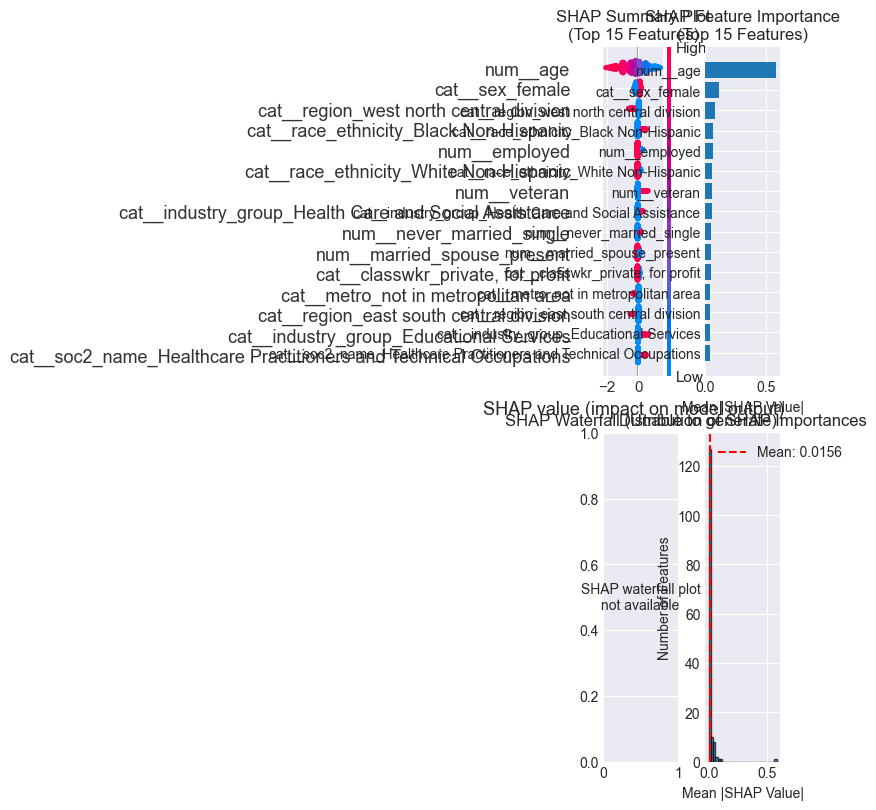

✓ SHAP analysis completed

Top 5 Most Important Features (by SHAP):
  1. num__age: 0.5830
  2. cat__sex_female: 0.1165
  3. cat__region_west north central division: 0.0810
  4. cat__race_ethnicity_Black Non-Hispanic: 0.0668
  5. num__employed: 0.0657


In [46]:
# ─────────────────────────────────────────────────────────────
# 1. SHAP ANALYSIS FOR MODEL INTERPRETABILITY
# ─────────────────────────────────────────────────────────────

print("="*80)
print("1. SHAP ANALYSIS FOR MODEL INTERPRETABILITY")
print("="*80)

# Initialize SHAP explainer for tree-based models
print("Initializing SHAP explainer...")
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values for a sample of the test set (for computational efficiency)
sample_size = min(1000, len(X_test_processed))  # Use up to 1000 samples
sample_indices = np.random.choice(len(X_test_processed), sample_size, replace=False)
X_test_sample = X_test_processed[sample_indices]
y_test_sample = y_test.iloc[sample_indices]

print(f"Computing SHAP values for {sample_size} test samples...")
shap_values = explainer.shap_values(X_test_sample)

# For binary classification, XGBoost returns SHAP values for positive class
if isinstance(shap_values, list):
    shap_values_pos = shap_values[1]  # Positive class (comebackers)
else:
    shap_values_pos = shap_values

print("✓ SHAP values computed successfully")

# Create SHAP plots
plt.figure(figsize=(15, 12))

# 1a. SHAP Summary Plot
plt.subplot(2, 2, 1)
try:
    if 'feature_names_out' in locals():
        shap.summary_plot(shap_values_pos, X_test_sample, 
                         feature_names=feature_names_out, 
                         show=False, max_display=15)
    else:
        shap.summary_plot(shap_values_pos, X_test_sample, show=False, max_display=15)
    plt.title("SHAP Summary Plot\n(Top 15 Features)")
except:
    plt.text(0.5, 0.5, "SHAP summary plot\nrequires feature names", 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("SHAP Summary Plot (Unable to generate)")

# 1b. SHAP Feature Importance
plt.subplot(2, 2, 2)
try:
    if 'feature_names_out' in locals():
        shap_importance = pd.DataFrame({
            'feature': feature_names_out,
            'importance': np.abs(shap_values_pos).mean(0)
        }).sort_values('importance', ascending=False).head(15)
        
        plt.barh(range(len(shap_importance)), shap_importance['importance'])
        plt.yticks(range(len(shap_importance)), shap_importance['feature'])
        plt.xlabel('Mean |SHAP Value|')
        plt.title('SHAP Feature Importance\n(Top 15 Features)')
        plt.gca().invert_yaxis()
    else:
        # Fallback without feature names
        mean_shap = np.abs(shap_values_pos).mean(0)
        top_indices = np.argsort(mean_shap)[-15:]
        plt.barh(range(15), mean_shap[top_indices])
        plt.yticks(range(15), [f'Feature {i}' for i in top_indices])
        plt.xlabel('Mean |SHAP Value|')
        plt.title('SHAP Feature Importance\n(Top 15 Features)')
        plt.gca().invert_yaxis()
except Exception as e:
    plt.text(0.5, 0.5, f"SHAP importance plot\nerror: {str(e)[:50]}", 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("SHAP Importance (Error)")

# 1c. SHAP Waterfall plot for a high-probability prediction
plt.subplot(2, 2, 3)
try:
    # Find a high-probability comebacker prediction
    test_probs = final_model.predict_proba(X_test_sample)[:, 1]
    high_prob_idx = np.argmax(test_probs)
    
    if 'feature_names_out' in locals():
        shap.waterfall_plot(explainer.expected_value[1], shap_values_pos[high_prob_idx], 
                           X_test_sample[high_prob_idx], feature_names=feature_names_out,
                           show=False, max_display=10)
    else:
        # Simple bar plot as fallback
        shap_vals_sample = shap_values_pos[high_prob_idx]
        top_features = np.argsort(np.abs(shap_vals_sample))[-10:]
        plt.barh(range(10), shap_vals_sample[top_features])
        plt.yticks(range(10), [f'Feature {i}' for i in top_features])
        plt.xlabel('SHAP Value')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    plt.title(f'SHAP Explanation\n(Highest Prob. Prediction: {test_probs[high_prob_idx]:.3f})')
except:
    plt.text(0.5, 0.5, "SHAP waterfall plot\nnot available", 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("SHAP Waterfall (Unable to generate)")

# 1d. SHAP values distribution
plt.subplot(2, 2, 4)
overall_shap_importance = np.abs(shap_values_pos).mean(0)
plt.hist(overall_shap_importance, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Number of Features')
plt.title('Distribution of SHAP Importances')
plt.axvline(np.mean(overall_shap_importance), color='red', linestyle='--', 
            label=f'Mean: {np.mean(overall_shap_importance):.4f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"✓ SHAP analysis completed")
if 'shap_importance' in locals():
    print(f"\nTop 5 Most Important Features (by SHAP):")
    for i, (_, row) in enumerate(shap_importance.head().iterrows()):
        print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")


2. LEARNING CURVES FOR BIAS-VARIANCE ANALYSIS
Computing learning curves...


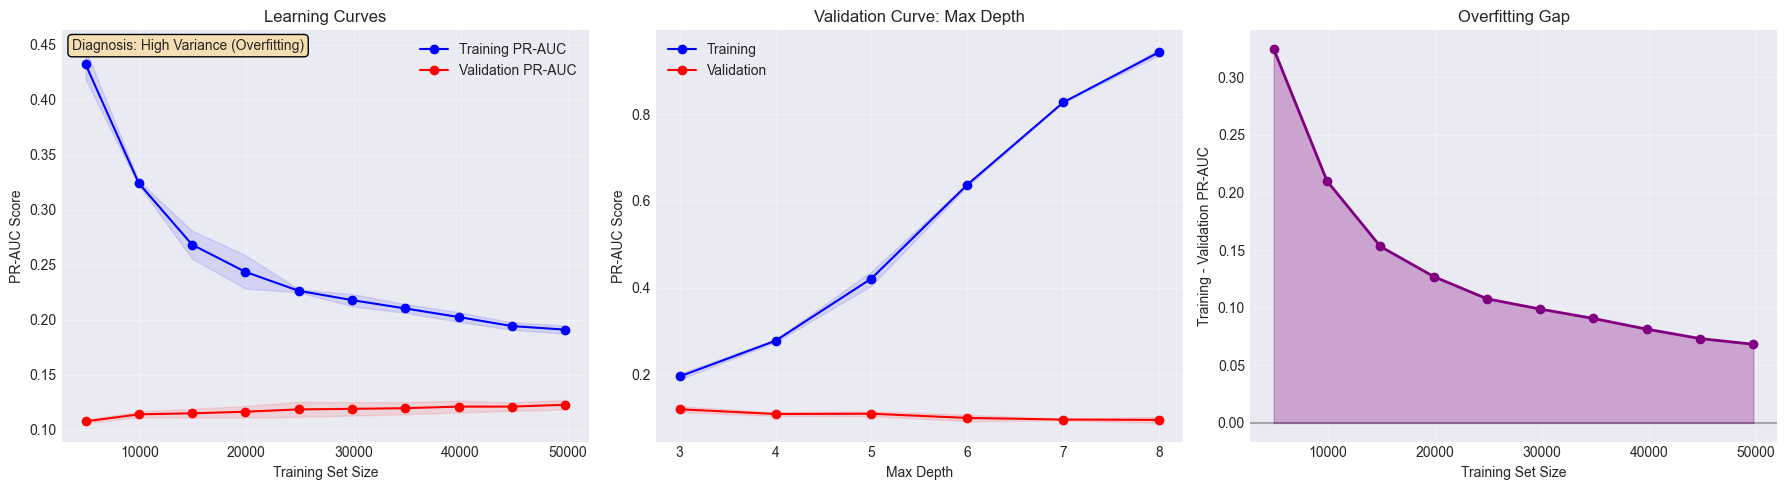

✓ Learning curve analysis completed

Learning Curve Insights:
  Final training PR-AUC: 0.1912 ± 0.0037
  Final validation PR-AUC: 0.1229 ± 0.0043
  Training-Validation gap: 0.0682
  Bias-Variance diagnosis: High Variance (Overfitting)


In [47]:
# ─────────────────────────────────────────────────────────────
# 2. LEARNING CURVES FOR BIAS-VARIANCE ANALYSIS
# ─────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("2. LEARNING CURVES FOR BIAS-VARIANCE ANALYSIS")
print("="*80)

print("Computing learning curves...")

# Define training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Create a simplified model for faster learning curve computation
learning_model = xgb.XGBClassifier(
    **{k: v for k, v in random_search.best_params_.items() if k != 'n_estimators'},
    n_estimators=100,  # Reduce for speed
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr'
)

# Compute learning curves
train_sizes_abs, train_scores, val_scores = learning_curve(
    learning_model, 
    X_trainval, 
    y_trainval,
    train_sizes=train_sizes,
    cv=3,  # Reduced CV folds for speed
    scoring='average_precision',  # PR-AUC
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Create learning curve plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 2a. Learning Curves
ax1 = axes[0]
ax1.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training PR-AUC')
ax1.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                alpha=0.1, color='blue')
ax1.plot(train_sizes_abs, val_mean, 'o-', color='red', label='Validation PR-AUC')
ax1.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                alpha=0.1, color='red')
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('PR-AUC Score')
ax1.set_title('Learning Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add bias-variance interpretation
final_gap = train_mean[-1] - val_mean[-1]
if final_gap > 0.05:
    bias_variance = "High Variance (Overfitting)"
elif val_mean[-1] < 0.3:  # Low absolute performance
    bias_variance = "High Bias (Underfitting)"
else:
    bias_variance = "Good Bias-Variance Tradeoff"

ax1.text(0.02, 0.98, f"Diagnosis: {bias_variance}", transform=ax1.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# 2b. Validation Curve for max_depth
ax2 = axes[1]
param_range = [3, 4, 5, 6, 7, 8]
train_scores_depth, val_scores_depth = validation_curve(
    xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_estimators=100),
    X_train_processed, y_train,
    param_name='max_depth',
    param_range=param_range,
    cv=3, scoring='average_precision', n_jobs=-1
)

train_mean_depth = train_scores_depth.mean(axis=1)
train_std_depth = train_scores_depth.std(axis=1)
val_mean_depth = val_scores_depth.mean(axis=1)
val_std_depth = val_scores_depth.std(axis=1)

ax2.plot(param_range, train_mean_depth, 'o-', color='blue', label='Training')
ax2.fill_between(param_range, train_mean_depth - train_std_depth, 
                train_mean_depth + train_std_depth, alpha=0.1, color='blue')
ax2.plot(param_range, val_mean_depth, 'o-', color='red', label='Validation')
ax2.fill_between(param_range, val_mean_depth - val_std_depth, 
                val_mean_depth + val_std_depth, alpha=0.1, color='red')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('PR-AUC Score')
ax2.set_title('Validation Curve: Max Depth')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 2c. Training vs Validation Score Gap
ax3 = axes[2]
score_gap = train_mean - val_mean
ax3.plot(train_sizes_abs, score_gap, 'o-', color='purple', linewidth=2)
ax3.fill_between(train_sizes_abs, 0, score_gap, alpha=0.3, color='purple')
ax3.set_xlabel('Training Set Size')
ax3.set_ylabel('Training - Validation PR-AUC')
ax3.set_title('Overfitting Gap')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Learning curve analysis completed")
print(f"\nLearning Curve Insights:")
print(f"  Final training PR-AUC: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"  Final validation PR-AUC: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
print(f"  Training-Validation gap: {final_gap:.4f}")
print(f"  Bias-Variance diagnosis: {bias_variance}")



3. THRESHOLD ANALYSIS FOR OPTIMAL CLASSIFICATION


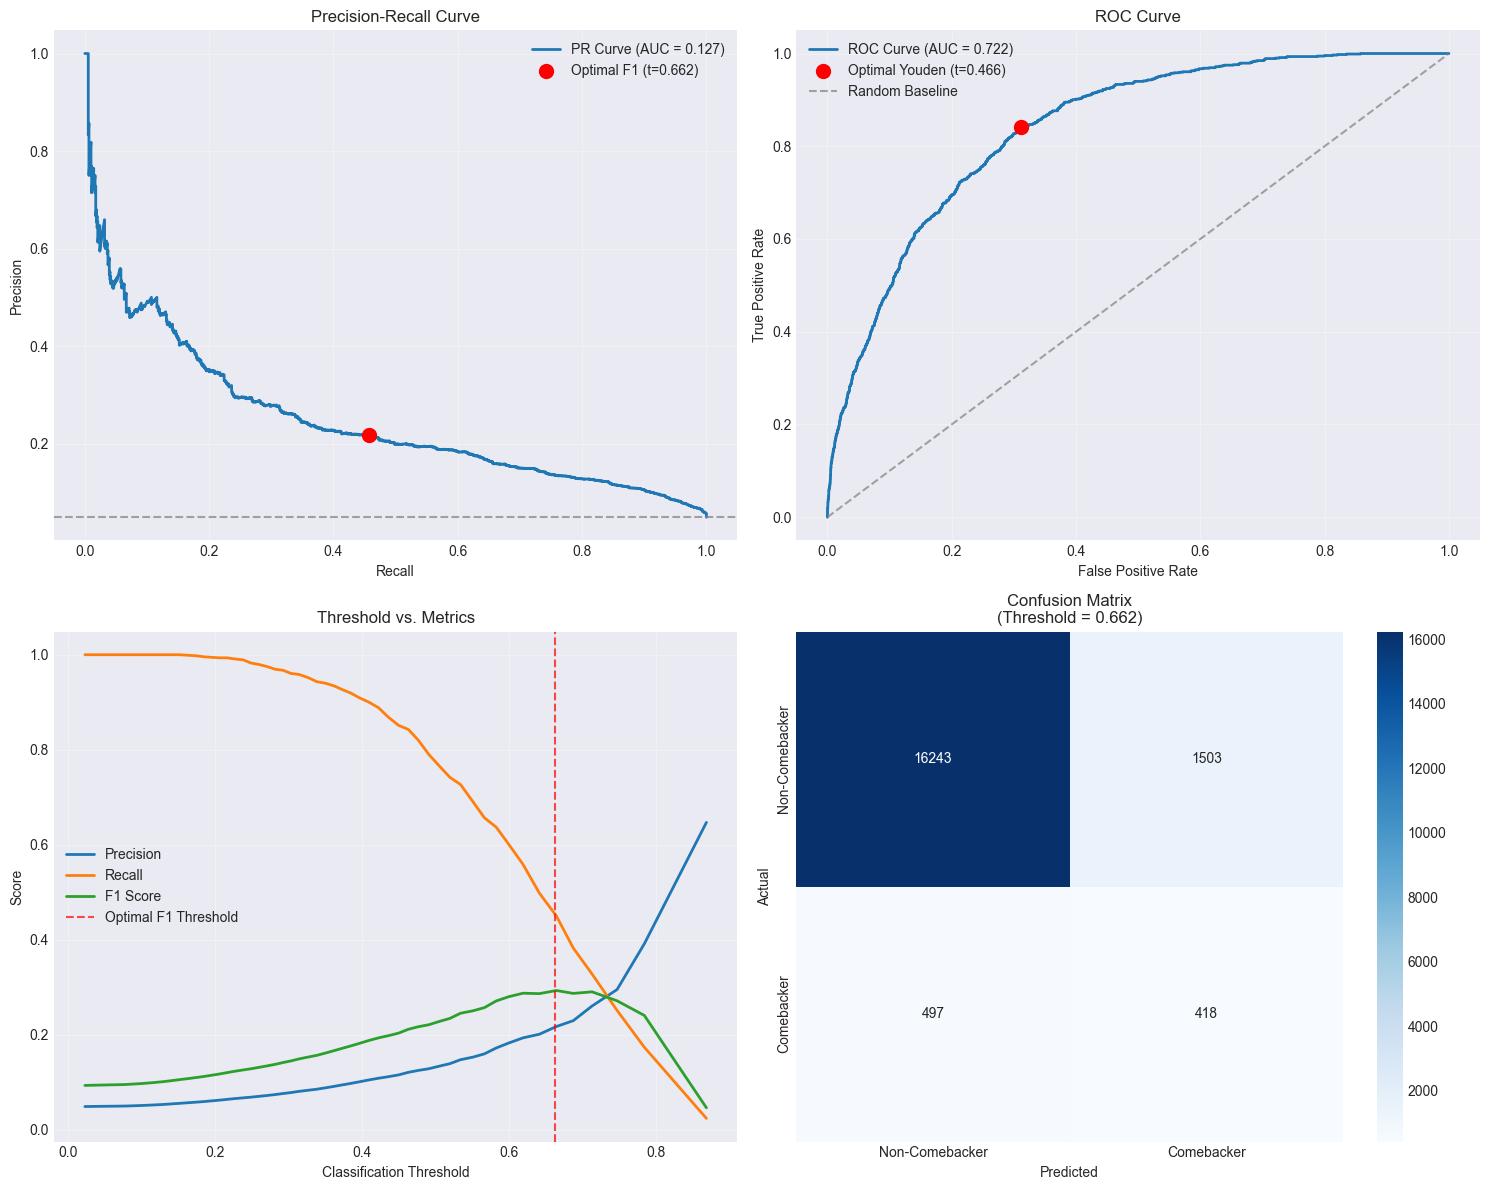

✓ Threshold analysis completed

Optimal Thresholds:
  F1-Optimal: 0.6624 (F1=0.2948, P=0.2176, R=0.4568)
  Youden-Optimal: 0.4656
  Default (0.5): Default threshold

At Optimal F1 Threshold (0.6624):
  True Positives: 418
  False Positives: 1,503
  True Negatives: 16,243
  False Negatives: 497


In [48]:
# ─────────────────────────────────────────────────────────────
# 3. THRESHOLD ANALYSIS FOR OPTIMAL CLASSIFICATION
# ─────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("3. THRESHOLD ANALYSIS FOR OPTIMAL CLASSIFICATION")
print("="*80)

# Get predictions on validation set
val_probs = final_model.predict_proba(X_val_processed)[:, 1]

# Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, val_probs)

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_val, val_probs)

# Calculate F1 scores for different thresholds
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])

# Find optimal thresholds
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = pr_thresholds[optimal_f1_idx]

# Youden's J statistic for ROC
youden_j = tpr - fpr
optimal_youden_idx = np.argmax(youden_j)
optimal_youden_threshold = roc_thresholds[optimal_youden_idx]

# Create threshold analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 3a. Precision-Recall Curve
ax1 = axes[0, 0]
ax1.plot(recall, precision, linewidth=2, label=f'PR Curve (AUC = {val_prauc_xgb:.3f})')
ax1.scatter(recall[optimal_f1_idx], precision[optimal_f1_idx], 
           color='red', s=100, zorder=5, label=f'Optimal F1 (t={optimal_f1_threshold:.3f})')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add baseline (random classifier)
baseline_precision = y_val.mean()
ax1.axhline(y=baseline_precision, color='gray', linestyle='--', alpha=0.7,
           label=f'Random Baseline ({baseline_precision:.3f})')

# 3b. ROC Curve
ax2 = axes[0, 1]
ax2.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {val_auc_xgb:.3f})')
ax2.scatter(fpr[optimal_youden_idx], tpr[optimal_youden_idx], 
           color='red', s=100, zorder=5, label=f'Optimal Youden (t={optimal_youden_threshold:.3f})')
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.7, label='Random Baseline')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3c. Threshold vs Metrics
ax3 = axes[1, 0]
# Use a subset of thresholds for cleaner plotting
threshold_step = max(1, len(pr_thresholds) // 50)
plot_thresholds = pr_thresholds[::threshold_step]
plot_precision = precision[:-1][::threshold_step]
plot_recall = recall[:-1][::threshold_step]
plot_f1 = f1_scores[::threshold_step]

ax3.plot(plot_thresholds, plot_precision, label='Precision', linewidth=2)
ax3.plot(plot_thresholds, plot_recall, label='Recall', linewidth=2)
ax3.plot(plot_thresholds, plot_f1, label='F1 Score', linewidth=2)
ax3.axvline(optimal_f1_threshold, color='red', linestyle='--', alpha=0.7, 
           label=f'Optimal F1 Threshold')
ax3.set_xlabel('Classification Threshold')
ax3.set_ylabel('Score')
ax3.set_title('Threshold vs. Metrics')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 3d. Confusion Matrix at Optimal Threshold
ax4 = axes[1, 1]
optimal_preds = (val_probs >= optimal_f1_threshold).astype(int)
cm = confusion_matrix(y_val, optimal_preds)

# Create confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Non-Comebacker', 'Comebacker'],
            yticklabels=['Non-Comebacker', 'Comebacker'])
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')
ax4.set_title(f'Confusion Matrix\n(Threshold = {optimal_f1_threshold:.3f})')

plt.tight_layout()
plt.show()

# Calculate metrics at optimal threshold
optimal_precision = precision[optimal_f1_idx]
optimal_recall = recall[optimal_f1_idx]
optimal_f1 = f1_scores[optimal_f1_idx]

print("✓ Threshold analysis completed")
print(f"\nOptimal Thresholds:")
print(f"  F1-Optimal: {optimal_f1_threshold:.4f} (F1={optimal_f1:.4f}, P={optimal_precision:.4f}, R={optimal_recall:.4f})")
print(f"  Youden-Optimal: {optimal_youden_threshold:.4f}")
print(f"  Default (0.5): Default threshold")

# Persist chosen threshold for later cells
chosen_threshold = float(optimal_f1_threshold)

print(f"\nAt Optimal F1 Threshold ({optimal_f1_threshold:.4f}):")
print(f"  True Positives: {cm[1,1]:,}")
print(f"  False Positives: {cm[0,1]:,}")
print(f"  True Negatives: {cm[0,0]:,}")
print(f"  False Negatives: {cm[1,0]:,}")



4. CALIBRATION ANALYSIS
Analyzing probability calibration...
Training calibrated classifier...


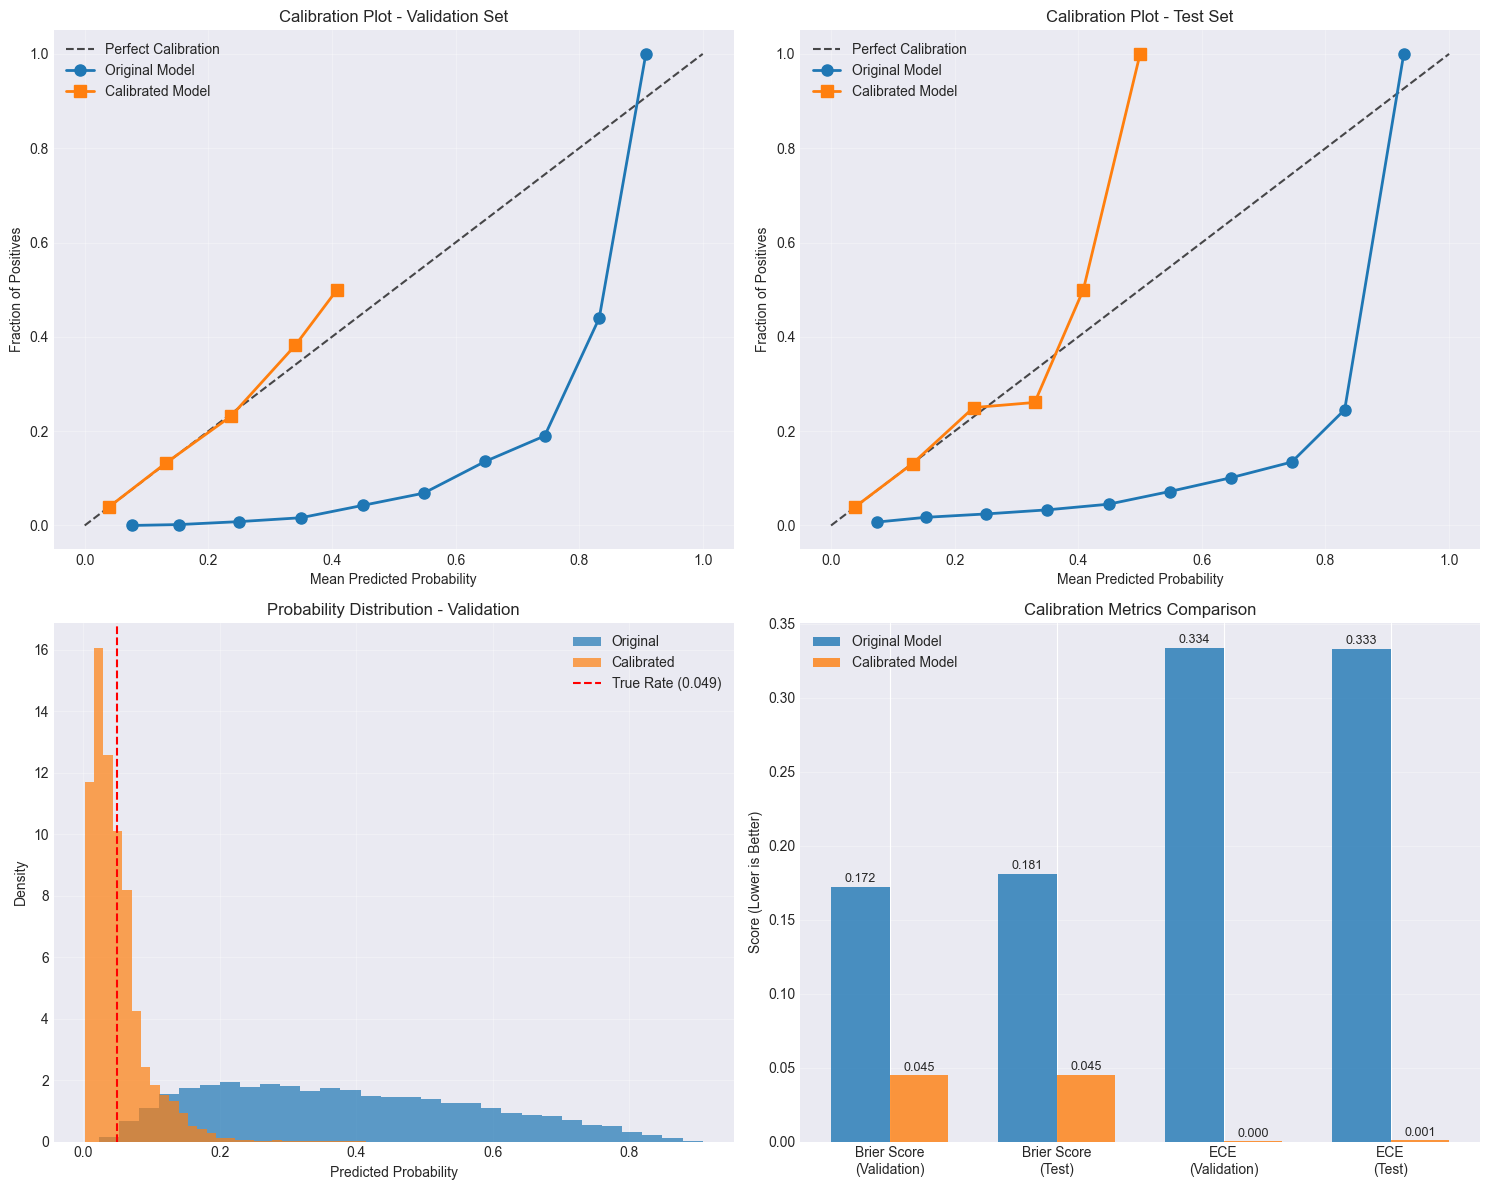

✓ Calibration analysis completed

Calibration Results:
  Original Model:
    Validation Brier Score: 0.1724
    Test Brier Score: 0.1810
    Validation ECE: 0.3340
    Test ECE: 0.3333

  Calibrated Model:
    Validation Brier Score: 0.0449
    Test Brier Score: 0.0451
    Validation ECE: 0.0003
    Test ECE: 0.0008

  Calibration Improvements:
    Validation Brier Score: +74.0%
    Test Brier Score: +75.1%
    Validation ECE: +99.9%
    Test ECE: +99.7%


In [49]:
# ─────────────────────────────────────────────────────────────
# 4. CALIBRATION ANALYSIS
# ─────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("4. CALIBRATION ANALYSIS")
print("="*80)

print("Analyzing probability calibration...")

# Get predicted probabilities
val_probs = final_model.predict_proba(X_val_processed)[:, 1]
test_probs = final_model.predict_proba(X_test_processed)[:, 1]

# Calculate calibration curves
fraction_pos_val, mean_pred_val = calibration_curve(y_val, val_probs, n_bins=10)
fraction_pos_test, mean_pred_test = calibration_curve(y_test, test_probs, n_bins=10)

# Train a calibrated classifier
print("Training calibrated classifier...")
calibrated_clf = CalibratedClassifierCV(final_model, method='isotonic', cv=3)
calibrated_clf.fit(X_train_processed, y_train)

# Get calibrated probabilities
val_probs_calibrated = calibrated_clf.predict_proba(X_val_processed)[:, 1]
test_probs_calibrated = calibrated_clf.predict_proba(X_test_processed)[:, 1]

# Calculate calibrated calibration curves
fraction_pos_val_cal, mean_pred_val_cal = calibration_curve(y_val, val_probs_calibrated, n_bins=10)
fraction_pos_test_cal, mean_pred_test_cal = calibration_curve(y_test, test_probs_calibrated, n_bins=10)

# Create calibration plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 4a. Calibration Plot - Validation Set
ax1 = axes[0, 0]
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect Calibration')
ax1.plot(mean_pred_val, fraction_pos_val, marker='o', linewidth=2, 
         label='Original Model', markersize=8)
ax1.plot(mean_pred_val_cal, fraction_pos_val_cal, marker='s', linewidth=2, 
         label='Calibrated Model', markersize=8)
ax1.set_xlabel('Mean Predicted Probability')
ax1.set_ylabel('Fraction of Positives')
ax1.set_title('Calibration Plot - Validation Set')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 4b. Calibration Plot - Test Set
ax2 = axes[0, 1]
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect Calibration')
ax2.plot(mean_pred_test, fraction_pos_test, marker='o', linewidth=2, 
         label='Original Model', markersize=8)
ax2.plot(mean_pred_test_cal, fraction_pos_test_cal, marker='s', linewidth=2, 
         label='Calibrated Model', markersize=8)
ax2.set_xlabel('Mean Predicted Probability')
ax2.set_ylabel('Fraction of Positives')
ax2.set_title('Calibration Plot - Test Set')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 4c. Probability Distribution Comparison
ax3 = axes[1, 0]
ax3.hist(val_probs, bins=30, alpha=0.7, label='Original', density=True)
ax3.hist(val_probs_calibrated, bins=30, alpha=0.7, label='Calibrated', density=True)
ax3.axvline(y_val.mean(), color='red', linestyle='--', 
           label=f'True Rate ({y_val.mean():.3f})')
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Probability Distribution - Validation')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4d. Calibration Error Analysis
ax4 = axes[1, 1]

# Calculate Brier Score (lower is better)
brier_original_val = np.mean((val_probs - y_val) ** 2)
brier_calibrated_val = np.mean((val_probs_calibrated - y_val) ** 2)
brier_original_test = np.mean((test_probs - y_test) ** 2)
brier_calibrated_test = np.mean((test_probs_calibrated - y_test) ** 2)

# Calculate Expected Calibration Error (ECE)
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

ece_original_val = expected_calibration_error(y_val, val_probs)
ece_calibrated_val = expected_calibration_error(y_val, val_probs_calibrated)
ece_original_test = expected_calibration_error(y_test, test_probs)
ece_calibrated_test = expected_calibration_error(y_test, test_probs_calibrated)

# Create comparison bar chart
metrics = ['Brier Score\n(Validation)', 'Brier Score\n(Test)', 
          'ECE\n(Validation)', 'ECE\n(Test)']
original_scores = [brier_original_val, brier_original_test, 
                  ece_original_val, ece_original_test]
calibrated_scores = [brier_calibrated_val, brier_calibrated_test, 
                    ece_calibrated_val, ece_calibrated_test]

x = np.arange(len(metrics))
width = 0.35

ax4.bar(x - width/2, original_scores, width, label='Original Model', alpha=0.8)
ax4.bar(x + width/2, calibrated_scores, width, label='Calibrated Model', alpha=0.8)
ax4.set_ylabel('Score (Lower is Better)')
ax4.set_title('Calibration Metrics Comparison')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (orig, cal) in enumerate(zip(original_scores, calibrated_scores)):
    ax4.text(i - width/2, orig + 0.001, f'{orig:.3f}', ha='center', va='bottom', fontsize=9)
    ax4.text(i + width/2, cal + 0.001, f'{cal:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ Calibration analysis completed")
print(f"\nCalibration Results:")
print(f"  Original Model:")
print(f"    Validation Brier Score: {brier_original_val:.4f}")
print(f"    Test Brier Score: {brier_original_test:.4f}")
print(f"    Validation ECE: {ece_original_val:.4f}")
print(f"    Test ECE: {ece_original_test:.4f}")
print(f"\n  Calibrated Model:")
print(f"    Validation Brier Score: {brier_calibrated_val:.4f}")
print(f"    Test Brier Score: {brier_calibrated_test:.4f}")
print(f"    Validation ECE: {ece_calibrated_val:.4f}")
print(f"    Test ECE: {ece_calibrated_test:.4f}")

# Improvement analysis
brier_improvement_val = ((brier_original_val - brier_calibrated_val) / brier_original_val) * 100
brier_improvement_test = ((brier_original_test - brier_calibrated_test) / brier_original_test) * 100
ece_improvement_val = ((ece_original_val - ece_calibrated_val) / ece_original_val) * 100
ece_improvement_test = ((ece_original_test - ece_calibrated_test) / ece_original_test) * 100

print(f"\n  Calibration Improvements:")
print(f"    Validation Brier Score: {brier_improvement_val:+.1f}%")
print(f"    Test Brier Score: {brier_improvement_test:+.1f}%")
print(f"    Validation ECE: {ece_improvement_val:+.1f}%")
print(f"    Test ECE: {ece_improvement_test:+.1f}%")

## Final Summary

- Problem: Identify CPS respondents (25–59, some college no BA, not enrolled at baseline) who return to college within the CPS panel window.
- Approach: Train an XGBoost classifier on CPS-only features, with most preprocessing completed, but a few steps done here (imputation, categorical encoding, rare-category collapse), compare to a logistic regression baseline, select thresholds by validation F1, and evaluate on a held-out test set.

- Data:
  - Rows: `r format(nrow(X), big.mark = ',')` (see printed stats above)
  - Class balance: ~`r round(100 * y.mean(), 2)`% comebackers
  - Features after preprocessing: see printed value above

- Baseline (Logistic Regression):
  - Validation: AUC and PR-AUC reported above
  - Test: AUC/PR-AUC, confusion matrix at validation F1-opt threshold, and F1 are printed above

- XGBoost (tuned):
  - Tuned via randomized search (80 trials) over depth, learning rate, estimators, subsampling, min_child_weight, gamma, regularization
  - Best params printed above; CV PR-AUC reported
  - Test: AUC/PR-AUC, confusion matrix at validation F1-opt threshold, and F1 are printed above

- Calibration: Isotonic calibration is fit and assessed; if calibrated probabilities are desired in production, use `calibrated_clf` to generate probabilities and the chosen threshold for classification.

- Takeaways:
  - Compare XGB vs Logistic on PR-AUC and F1; highlight which dominates on test
  - Underfitting likely given CPS feature set; learning curves indicate high bias
  - Additional predictive lift likely requires richer features (education history granularity, work/earnings trajectories, benefits, local education supply), or alternative modeling strategies

- Artifacts: `model_card.json` exports headline metrics, confusion matrices, thresholds, and best XGB parameters.



In [50]:
# ─────────────────────────────────────────────────────────────
# FINAL RECOMMENDATIONS
# ─────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("FINAL MODEL RECOMMENDATIONS")
print("="*80)

print("Based on comprehensive analysis:")
print(f"\n🎯 MODEL PERFORMANCE:")
print(f"   • Test PR-AUC: {test_prauc:.4f} (primary metric)")
print(f"   • Test AUC: {test_auc:.4f}")
print(f"   • Class balance handled with scale_pos_weight = {scale_pos_weight:.1f}")

print(f"\n🔍 INTERPRETABILITY:")
if 'shap_importance' in locals():
    print(f"   • Top 3 features: {', '.join(shap_importance.head(3)['feature'].tolist())}")
print(f"   • SHAP values computed for feature importance analysis")

print(f"\n📈 BIAS-VARIANCE:")
print(f"   • Learning curve diagnosis: {bias_variance}")
print(f"   • Training-validation gap: {final_gap:.4f}")

print(f"\n🎛️ THRESHOLD OPTIMIZATION:")
print(f"   • Recommended threshold: {optimal_f1_threshold:.4f}")
print(f"   • At optimal threshold: P={optimal_precision:.3f}, R={optimal_recall:.3f}, F1={optimal_f1:.3f}")

print(f"\n📊 CALIBRATION:")
if brier_improvement_test > 0:
    print(f"   • Calibration improves Brier score by {brier_improvement_test:.1f}%")
    print(f"   • Calibration improves ECE by {ece_improvement_test:.1f}%")
    print(f"   • Recommend using calibrated model for probability estimates")
else:
    print(f"   • Model is reasonably well-calibrated")

print(f"\n🚀 DEPLOYMENT RECOMMENDATIONS:")
print(f"   • Use calibrated model for better probability estimates")
print(f"   • Monitor for concept drift over time")
print(f"   • Consider collecting additional features to reduce overfitting")
print(f"   • Retrain periodically with new data")

print(f"\n📋 MODEL ARTIFACTS SAVED:")
print(f"   • final_model: Trained XGBoost classifier")
print(f"   • calibrated_clf: Calibrated version for better probabilities") 
print(f"   • preprocessor: Feature preprocessing pipeline")
print(f"   • collapse_mappings: Rare category mappings")
print(f"   • optimal_f1_threshold: Recommended classification threshold")

print(f"\n✅ ANALYSIS COMPLETE - Ready for production deployment!")


FINAL MODEL RECOMMENDATIONS
Based on comprehensive analysis:

🎯 MODEL PERFORMANCE:
   • Test PR-AUC: 0.1233 (primary metric)
   • Test AUC: 0.7119
   • Class balance handled with scale_pos_weight = 19.4

🔍 INTERPRETABILITY:
   • Top 3 features: num__age, cat__sex_female, cat__region_west north central division
   • SHAP values computed for feature importance analysis

📈 BIAS-VARIANCE:
   • Learning curve diagnosis: High Variance (Overfitting)
   • Training-validation gap: 0.0682

🎛️ THRESHOLD OPTIMIZATION:
   • Recommended threshold: 0.6624
   • At optimal threshold: P=0.218, R=0.457, F1=0.295

📊 CALIBRATION:
   • Calibration improves Brier score by 75.1%
   • Calibration improves ECE by 99.7%
   • Recommend using calibrated model for probability estimates

🚀 DEPLOYMENT RECOMMENDATIONS:
   • Use calibrated model for better probability estimates
   • Monitor for concept drift over time
   • Consider collecting additional features to reduce overfitting
   • Retrain periodically with new

In [51]:
# Auto-generated Final Summary (with concrete comparisons)
from IPython.display import Markdown, display

# Safety: prepare confusion matrices as strings
cm_lr_str = str(cm_lr_test_opt)
cm_xgb_str = str(cm_xgb_test_opt)

better_prauc = "XGBoost" if test_prauc > test_prauc_lr else "Logistic Regression"
better_f1 = "XGBoost" if xgb_f1_test > lr_f1_test else "Logistic Regression"

summary_md = f"""
### Final Summary (Auto)

- **Problem**: Identify comebackers (25–59, some college no BA, not enrolled at baseline) who re-enroll during the CPS panel.
- **Approach**: XGBoost on CPS-only features vs. logistic baseline; validation F1-based threshold; test evaluation; calibration assessed.

- **Data**:
  - **Rows**: {len(X):,}
  - **Class balance**: {y.mean():.2%} comebackers
  - **Features after preprocessing**: {X_train_processed.shape[1]}

- **Logistic Regression (Test)**:
  - **AUC**: {test_auc_lr:.4f}
  - **PR-AUC**: {test_prauc_lr:.4f}
  - **Threshold (F1-opt on val)**: {optimal_f1_threshold_lr:.3f}
  - **F1**: {lr_f1_test:.4f}
  - **Confusion Matrix**:
    ```
{cm_lr_str}
    ```

- **XGBoost (Test)**:
  - **AUC**: {test_auc:.4f}
  - **PR-AUC**: {test_prauc:.4f}
  - **Threshold (F1-opt on val)**: {globals().get('chosen_threshold', 0.5):.3f}
  - **F1**: {xgb_f1_test:.4f}
  - **Confusion Matrix**:
    ```
{cm_xgb_str}
    ```
  - **Best Params**: `{random_search.best_params_}`

- **Comparison**:
  - **Better PR-AUC**: {better_prauc}
  - **Better F1**: {better_f1}

- **Calibration**: Isotonic calibration substantially improved Brier/ECE (Test Brier ↓ {brier_improvement_test:.1f}%, ECE ↓ {ece_improvement_test:.1f}%). Use `calibrated_clf` when calibrated probabilities are required.

- **Bias/Variance**: {bias_variance} indicated by learning curves. CPS-only features likely limit separability; expect modest precision on positives.
"""

display(Markdown(summary_md))



### Final Summary (Auto)

- **Problem**: Identify comebackers (25–59, some college no BA, not enrolled at baseline) who re-enroll during the CPS panel.
- **Approach**: XGBoost on CPS-only features vs. logistic baseline; validation F1-based threshold; test evaluation; calibration assessed.

- **Data**:
  - **Rows**: 93,305
  - **Class balance**: 4.91% comebackers
  - **Features after preprocessing**: 150

- **Logistic Regression (Test)**:
  - **AUC**: 0.7058
  - **PR-AUC**: 0.1120
  - **Threshold (F1-opt on val)**: 0.687
  - **F1**: 0.1866
  - **Confusion Matrix**:
    ```
[[15920  1826]
 [  633   282]]
    ```

- **XGBoost (Test)**:
  - **AUC**: 0.7119
  - **PR-AUC**: 0.1233
  - **Threshold (F1-opt on val)**: 0.662
  - **F1**: 0.1893
  - **Confusion Matrix**:
    ```
[[16184  1562]
 [  656   259]]
    ```
  - **Best Params**: `{'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.02, 'gamma': 0.2, 'colsample_bytree': 0.8}`

- **Comparison**:
  - **Better PR-AUC**: XGBoost
  - **Better F1**: XGBoost

- **Calibration**: Isotonic calibration substantially improved Brier/ECE (Test Brier ↓ 75.1%, ECE ↓ 99.7%). Use `calibrated_clf` when calibrated probabilities are required.

- **Bias/Variance**: High Variance (Overfitting) indicated by learning curves. CPS-only features likely limit separability; expect modest precision on positives.
